<h2>Creating Class-wise Unlearnable Examples</h2>

<h3>Prepare Data</h3>

In [1]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=False, download=True, transform=test_transform)

clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=6)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


<h3>Prepare Model</h3>

In [2]:
from models.ResNet import ResNet18

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)



<h3>Prepare Perturbation Generator Tool</h3>

In [3]:
import numpy as np
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


class PerturbationTool():
    def __init__(self, seed=0, epsilon=0.03137254901, num_steps=20, step_size=0.00784313725):
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.seed = seed
        np.random.seed(seed)

    def random_noise(self, noise_shape=[10, 3, 32, 32]):
        random_noise = torch.FloatTensor(*noise_shape).uniform_(-self.epsilon, self.epsilon).to(device)
        return random_noise

    def min_min_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)

        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)
        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                if hasattr(model, 'classify'):
                    model.classify = True
                logits = model(perturb_img)
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)
            perturb_img.retain_grad()
            loss.backward()
            eta = self.step_size * perturb_img.grad.data.sign() * (-1)
            perturb_img = Variable(perturb_img.data + eta, requires_grad=True)
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)

        return perturb_img, eta

    
noise_generator = PerturbationTool(epsilon=16/255, num_steps=10, step_size=4/255)


### Test noise_generator
images= torch.randn([1,3,32,32]).cuda()
labels= torch.ones([1]).long().cuda()

# noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
#                                                           random_noise=torch.zeros_like(images).cuda())


<h3>Generate Class-wise Error-Minimizing Noise</h3>

In [4]:
from tqdm import tqdm
import collections

### Final noise####
noise = torch.zeros([10, 3, 32, 32])

data_iter = iter(clean_train_loader)
condition = True
train_idx = 0

while condition:
    # optimize base model for 10 steps （train base models with 10 batches）
    base_model.train()
    for param in base_model.parameters():
        param.requires_grad = True
    for j in range(0, 10):
        #############Optimization of base model on data with noise#################
        #####1. each iteration is a batch, you may use next(data_iter) to get images and labels for training
        #### Point 2
        try:
            imgs, labels = next(data_iter)
        except:
            train_idx = 0
            data_iter = iter(clean_train_loader)
            imgs, labels = next(data_iter)
        imgs = imgs.to(device)
        labels = labels.to(device)
        imgs_noise = []
        for i, (img, label) in enumerate(zip(imgs, labels)):
            cls_noise = noise[label.item()]
            imgs_noise.append(img.cpu() + cls_noise.cpu())
        train_imgs = torch.stack(imgs_noise).to(device)
        
        base_model.zero_grad()
        optimizer.zero_grad()
        logits = base_model(train_imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    # Perturbation over entire dataset
    idx = 0
    for param in base_model.parameters():
        param.requires_grad = False
    for i, (images, labels) in tqdm(enumerate(clean_train_loader), total=len(clean_train_loader)):
        batch_start_idx, batch_noise = idx, []
        tmp_idx = 0
        for i, _ in enumerate(images):
            # Update noise to images
            batch_noise.append(noise[labels[tmp_idx]])
            idx += 1
            tmp_idx += 1
        batch_noise = torch.stack(batch_noise).cuda()
        
        # Update class-wise perturbation
        base_model.eval()
        images, labels = images.cuda(), labels.cuda()
        perturb_img, eta = noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
                                                          random_noise=batch_noise)
        
        #################Update noise by perturb_img or eta####################
        #### Point 2
        new_noise = torch.zeros([10, 3, 32, 32])
        label_count = [0] * 10
        for label, delta in zip(labels, eta):
            # print(eta.shape, labels.shape)
            label_count[label] += 1
            new_noise[label] += delta.detach().cpu()
        
        for label in range(10):
            noise[label] = (new_noise[label] / label_count[label]).clone().detach().cpu()
            
        
    # Eval stop condition
    eval_idx, total, correct = 0, 0, 0
    for i, (images, labels) in enumerate(clean_train_loader):
        eval_idx = 0
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[labels[eval_idx]]
            eval_idx += 1
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = base_model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('Accuracy %.2f' % (acc*100))
    if acc > 0.9:
        condition=False    


100%|██████████| 98/98 [04:34<00:00,  2.80s/it]


Accuracy 9.98


100%|██████████| 98/98 [04:25<00:00,  2.71s/it]


Accuracy 16.11


100%|██████████| 98/98 [04:32<00:00,  2.78s/it]


Accuracy 19.05


100%|██████████| 98/98 [04:32<00:00,  2.78s/it]


Accuracy 17.39


100%|██████████| 98/98 [04:32<00:00,  2.78s/it]


Accuracy 36.02


100%|██████████| 98/98 [04:33<00:00,  2.79s/it]


Accuracy 46.66


100%|██████████| 98/98 [04:28<00:00,  2.74s/it]


Accuracy 82.45


100%|██████████| 98/98 [04:31<00:00,  2.77s/it]


Accuracy 93.09


In [5]:
# Examine the noise
print(noise)

tensor([[[[ 4.5752e-02,  5.4715e-02, -1.7997e-02,  ..., -5.0961e-02,
           -5.3150e-02, -5.3052e-02],
          [-6.1251e-02, -5.7516e-02, -3.5482e-02,  ..., -5.3517e-02,
           -5.7187e-02, -5.8749e-02],
          [-3.7324e-02,  3.9644e-03,  2.0573e-02,  ..., -4.7476e-02,
           -5.0731e-02, -5.4170e-02],
          ...,
          [ 4.1590e-02,  1.7625e-02,  4.9608e-02,  ...,  1.8801e-03,
           -2.1454e-02, -4.6120e-02],
          [ 4.4374e-02,  5.2043e-02,  5.2661e-02,  ...,  3.6295e-02,
            3.0999e-02, -1.9939e-02],
          [ 2.7951e-02,  3.0003e-02,  4.9171e-02,  ...,  4.4914e-02,
            4.8463e-02,  1.6823e-02]],

         [[-6.1251e-02, -6.1251e-02, -4.7155e-02,  ...,  4.1816e-02,
            4.1598e-02,  4.2195e-02],
          [-5.7516e-02, -5.8263e-02, -2.5049e-02,  ...,  4.4141e-02,
            4.5797e-02,  4.7621e-02],
          [-3.8176e-02,  9.8008e-03,  3.8739e-02,  ...,  5.3968e-02,
            5.3720e-02,  5.3392e-02],
          ...,
     

<h3>Creat Unlearnable class-wise min-min Dataset</h3>

In [6]:
import numpy as np

# Add standard augmentation
train_transform = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
clean_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
unlearnable_train_dataset = datasets.CIFAR10(root='./data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)

##########Add the generated noise to the clean dataset to generate the unlearnable dataset###########
##########Point 2, you can refer to such part in samplewise.ipynb
preturb_noise = noise.mul(255).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu').numpy()
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.float32)
for i in range(len(unlearnable_train_dataset)):
    unlearnable_train_dataset.data[i] += preturb_noise[unlearnable_train_dataset.targets[i]]
    unlearnable_train_dataset.data[i] = np.clip(unlearnable_train_dataset.data[i], a_min=0, a_max=255)
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.uint8)

Files already downloaded and verified
Files already downloaded and verified


<h3>Visualize Clean Images, Error-Minimizing Noise, Unlearnable Images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


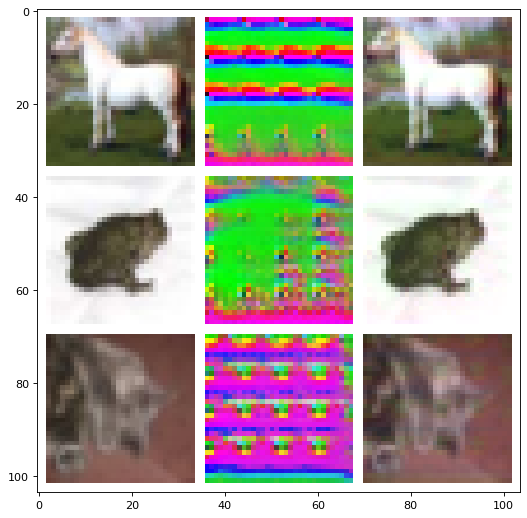

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = clean_train_dataset.data[idx]
    unlearnable_img = unlearnable_train_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    x = noise[unlearnable_train_dataset.targets[idx]]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, noise_norm, unlearnable_img]
    
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))



<h3>Train ResNet18 on Unlearnable Dataset</h3>

In [8]:
from util import AverageMeter

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=6)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
            

Acc 67.06 Loss: 0.96: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]


Clean Accuracy 13.24



Acc 97.34 Loss: 0.08: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


Clean Accuracy 10.62



Acc 98.75 Loss: 0.04: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Clean Accuracy 10.24



Acc 99.02 Loss: 0.03: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Clean Accuracy 11.01



Acc 99.15 Loss: 0.03: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


Clean Accuracy 10.26



Acc 99.33 Loss: 0.02: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Clean Accuracy 10.06



Acc 99.54 Loss: 0.02: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Clean Accuracy 10.03



Acc 99.65 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Clean Accuracy 10.15



Acc 99.75 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


Clean Accuracy 10.25



Acc 99.69 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Clean Accuracy 10.14



Acc 99.80 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


Clean Accuracy 10.17



Acc 99.80 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 10.11



Acc 99.74 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 10.24



Acc 99.91 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 10.05



Acc 99.90 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Clean Accuracy 10.24



Acc 99.88 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 10.16



Acc 99.89 Loss: 0.01: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Clean Accuracy 10.17



Acc 99.91 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 10.09



Acc 99.94 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 10.08



Acc 99.91 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 10.24



Acc 99.96 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Clean Accuracy 10.07



Acc 99.96 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Clean Accuracy 10.03



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Clean Accuracy 10.07



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Clean Accuracy 10.06



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Clean Accuracy 10.04



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Clean Accuracy 10.04



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Clean Accuracy 10.04



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Clean Accuracy 10.05



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Clean Accuracy 10.04



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Clean Accuracy 10.03

